In [1]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14366111728310386817
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5733613568
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10324675524568702195
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU memory growth enabled")
else:
    print("No GPU detected")

GPU memory growth enabled


## Dataset Loading

In [2]:
data_path = 'datasets/eng_-french.csv'
data = pd.read_csv(data_path)  

In [3]:
print(data.head())

  English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2                    Run!               Courez !
3                    Who?                  Qui ?
4                    Wow!             Ça alors !


In [4]:
def preprocess_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s]', '', sentence)
    return sentence

In [5]:
english_sentences = [preprocess_text(sentence) for sentence in data["English words/sentences"].tolist()]
french_sentences = ["<start> " + preprocess_text(sentence) + " <end>" for sentence in data["French words/sentences"].tolist()]

In [6]:
english_train, english_test, french_train, french_test = train_test_split(
    english_sentences, french_sentences, test_size=0.2, random_state=42
)

In [7]:
# Tokenize sentences
english_tokenizer = Tokenizer()
english_tokenizer.fit_on_texts(english_train)
english_train_sequences = english_tokenizer.texts_to_sequences(english_train)
english_test_sequences = english_tokenizer.texts_to_sequences(english_test)

french_tokenizer = Tokenizer(filters='')
french_tokenizer.fit_on_texts(french_train)
french_train_sequences = french_tokenizer.texts_to_sequences(french_train)
french_test_sequences = french_tokenizer.texts_to_sequences(french_test)

In [8]:
max_english_len = max(len(seq) for seq in english_train_sequences)
max_french_len = max(len(seq) for seq in french_train_sequences)

In [9]:
print(english_tokenizer.word_index)

{'i': 1, 'you': 2, 'to': 3, 'the': 4, 'a': 5, 'is': 6, 'tom': 7, 'that': 8, 'he': 9, 'do': 10, 'of': 11, 'it': 12, 'this': 13, 'me': 14, 'in': 15, 'have': 16, 'dont': 17, 'was': 18, 'my': 19, 'for': 20, 'are': 21, 'im': 22, 'your': 23, 'what': 24, 'we': 25, 'be': 26, 'want': 27, 'not': 28, 'she': 29, 'know': 30, 'like': 31, 'on': 32, 'with': 33, 'can': 34, 'were': 35, 'his': 36, 'youre': 37, 'did': 38, 'all': 39, 'at': 40, 'how': 41, 'go': 42, 'think': 43, 'they': 44, 'him': 45, 'its': 46, 'and': 47, 'time': 48, 'about': 49, 'cant': 50, 'here': 51, 'very': 52, 'didnt': 53, 'get': 54, 'there': 55, 'no': 56, 'as': 57, 'her': 58, 'will': 59, 'if': 60, 'had': 61, 'one': 62, 'why': 63, 'just': 64, 'going': 65, 'up': 66, 'out': 67, 'has': 68, 'so': 69, 'ill': 70, 'need': 71, 'would': 72, 'good': 73, 'tell': 74, 'see': 75, 'an': 76, 'when': 77, 'come': 78, 'help': 79, 'really': 80, 'who': 81, 'from': 82, 'us': 83, 'mary': 84, 'by': 85, 'please': 86, 'should': 87, 'thats': 88, 'ive': 89, 'coul

In [10]:
print(french_tokenizer.word_index)

{'<start>': 1, '<end>': 2, 'je': 3, 'de': 4, 'pas': 5, 'que': 6, 'ne': 7, 'la': 8, 'le': 9, 'vous': 10, 'a': 11, 'il': 12, 'tom': 13, 'est': 14, 'un': 15, 'ce': 16, 'tu': 17, 'nous': 18, 'en': 19, 'les': 20, 'une': 21, 'jai': 22, 'me': 23, 'suis': 24, 'pour': 25, 'faire': 26, 'cest': 27, 'elle': 28, 'dans': 29, 'plus': 30, 'des': 31, 'qui': 32, 'tout': 33, 'te': 34, 'ma': 35, 'avec': 36, 'du': 37, 'fait': 38, 'mon': 39, 'veux': 40, 'si': 41, 'se': 42, 'au': 43, 'et': 44, 'quil': 45, 'cette': 46, 'y': 47, 'sont': 48, 'son': 49, 'sur': 50, 'trs': 51, 'votre': 52, 'tre': 53, 'tes': 54, 'pourquoi': 55, 'temps': 56, 'dit': 57, 'cela': 58, 'pense': 59, 't': 60, 'lui': 61, 'tait': 62, 'moi': 63, 'peux': 64, 'nest': 65, 'chose': 66, 'ils': 67, 'nai': 68, 'jamais': 69, 'sais': 70, 'ici': 71, 'comment': 72, 'o': 73, 'vraiment': 74, 'ton': 75, 'quelque': 76, 'bien': 77, 'dire': 78, 'estce': 79, 'sa': 80, 'tous': 81, 'toi': 82, 'beaucoup': 83, 'par': 84, 'personne': 85, 'besoin': 86, 'quelle': 87,

In [11]:
print(english_test_sequences)

[[94, 5, 765], [1, 287, 7, 18, 51], [41, 38, 4, 8616, 42], [89, 56, 216, 3, 120, 3, 49, 19, 636], [1, 80, 31, 13, 2884, 34, 1, 192, 12, 32], [24, 180, 3, 45], [94, 111, 181, 1360, 2, 31], [22, 28, 622, 3, 563], [4, 1371, 68, 670], [242, 149, 101, 117, 8, 12, 6, 308], [19, 186, 1317, 8, 239, 81, 90, 28, 101, 5, 534, 15, 511, 18, 1288], [131, 14, 502, 557], [332, 3622, 4, 324], [22, 28, 73, 182, 20, 2], [1, 750, 8, 242, 26, 1103], [13, 315, 18, 8019, 805, 4, 638], [56, 62, 15, 19, 365, 34, 10, 8], [37, 4, 62, 81, 2141, 14], [1362], [9, 1882, 85, 1070], [2, 184, 15, 99, 102, 3500], [89, 121, 2, 5, 1632, 426, 28, 3, 3913], [1095, 284, 47, 2, 59, 26, 2675], [1, 71, 276], [1, 6244, 23, 749], [3123, 34, 435], [46, 19, 156], [1, 43, 5633, 6, 4, 2131, 5784, 81, 199, 653], [34, 1, 191, 63, 13, 6, 69, 397, 3, 2], [4, 1036, 59, 209, 4, 457, 60, 2, 17, 306, 4, 449, 178], [1, 567, 783, 4, 949, 154, 1, 1473, 55, 18, 5, 5945, 15, 12], [1, 34, 123, 2, 104, 1804, 763], [35, 135, 4, 222, 227], [1, 498, 4

### Preparing data for the model

In [12]:
english_train_padded = pad_sequences(english_train_sequences, maxlen=max_english_len, padding="post")
english_test_padded  = pad_sequences(english_test_sequences, maxlen=max_english_len, padding="post")
french_train_padded  = pad_sequences(french_train_sequences, maxlen=max_french_len, padding="post")
french_test_padded   = pad_sequences(french_test_sequences, maxlen=max_french_len, padding="post")

In [13]:
# decoder input and output for training
decoder_train_input_data  = french_train_padded[:, :-1]
decoder_train_output_data = french_train_padded[:, 1:]

# decoder input and output for testing
decoder_test_input_data  = french_test_padded[:, :-1]
decoder_test_output_data = french_test_padded[:, 1:]

In [14]:
embedding_dim = 256  
latent_dim = 512  
num_english_tokens = len(english_tokenizer.word_index) + 1
num_french_tokens = len(french_tokenizer.word_index) + 1

In [15]:
# Encoder
encoder_inputs = Input(shape=(None,)) # sequences of any length
encoder_embedding = Embedding(input_dim=num_english_tokens, output_dim=embedding_dim)(encoder_inputs)
encoder_dropout = Dropout(0.2)(encoder_embedding)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_dropout)
encoder_states = [state_h, state_c]

In [16]:
# Decoder
decoder_inputs = Input(shape=(None,))
decoder_embedding = Embedding(input_dim=num_french_tokens, output_dim=embedding_dim)(decoder_inputs)
decoder_dropout = Dropout(0.2)(decoder_embedding)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_dropout, initial_state=encoder_states)
decoder_dense = Dense(num_french_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

In [17]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    3436800     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    7401472     ['input_2[0][0]']                
                                                                                              

In [19]:
checkpoint_callback = ModelCheckpoint(
    'english_to_french_translation.h5',
    save_best_only=True,
    save_weights_only=False,
    verbose=0
)

early_stopping_callback = EarlyStopping(
    patience=5,
    monitor='val_loss',
    restore_best_weights=True
)

reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    verbose=1,
    min_lr=1e-6
)

In [20]:
try:
    model = load_model('english_to_french_translation.h5')
    print("Resuming training from saved model.")
except:
    print("Starting new training.")

history = model.fit(
    [english_train_padded, decoder_train_input_data],
    np.expand_dims(decoder_train_output_data, -1),
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping_callback, checkpoint_callback]
)

Starting new training.
Epoch 1/50
1757/1757 [==============================] - 424s 237ms/step - loss: 0.7765 - accuracy: 0.8925 - val_loss: 0.6199 - val_accuracy: 0.9010
Epoch 2/50
1757/1757 [==============================] - 439s 250ms/step - loss: 0.5559 - accuracy: 0.9063 - val_loss: 0.5165 - val_accuracy: 0.9119
Epoch 3/50
1757/1757 [==============================] - 425s 242ms/step - loss: 0.4639 - accuracy: 0.9162 - val_loss: 0.4660 - val_accuracy: 0.9187
Epoch 4/50
1757/1757 [==============================] - 426s 242ms/step - loss: 0.3971 - accuracy: 0.9241 - val_loss: 0.4191 - val_accuracy: 0.9258
Epoch 5/50
1757/1757 [==============================] - 427s 243ms/step - loss: 0.3362 - accuracy: 0.9319 - val_loss: 0.3853 - val_accuracy: 0.9313
Epoch 6/50
1757/1757 [==============================] - 428s 243ms/step - loss: 0.2859 - accuracy: 0.9385 - val_loss: 0.3607 - val_accuracy: 0.9355
Epoch 7/50
1757/1757 [==============================] - 422s 240ms/step - loss: 0.2439 - 

In [20]:
# model.save("english_to_french_translation.h5")

In [21]:
test_loss, test_accuracy = model.evaluate(
    [english_test_padded, decoder_test_input_data],
    np.expand_dims(decoder_test_output_data, -1),
    batch_size=64
)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

549/549 [==============================] - 49s 89ms/step - loss: 0.2998 - accuracy: 0.9472
Test Loss: 0.29984250664711
Test Accuracy: 0.9471989870071411


In [22]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

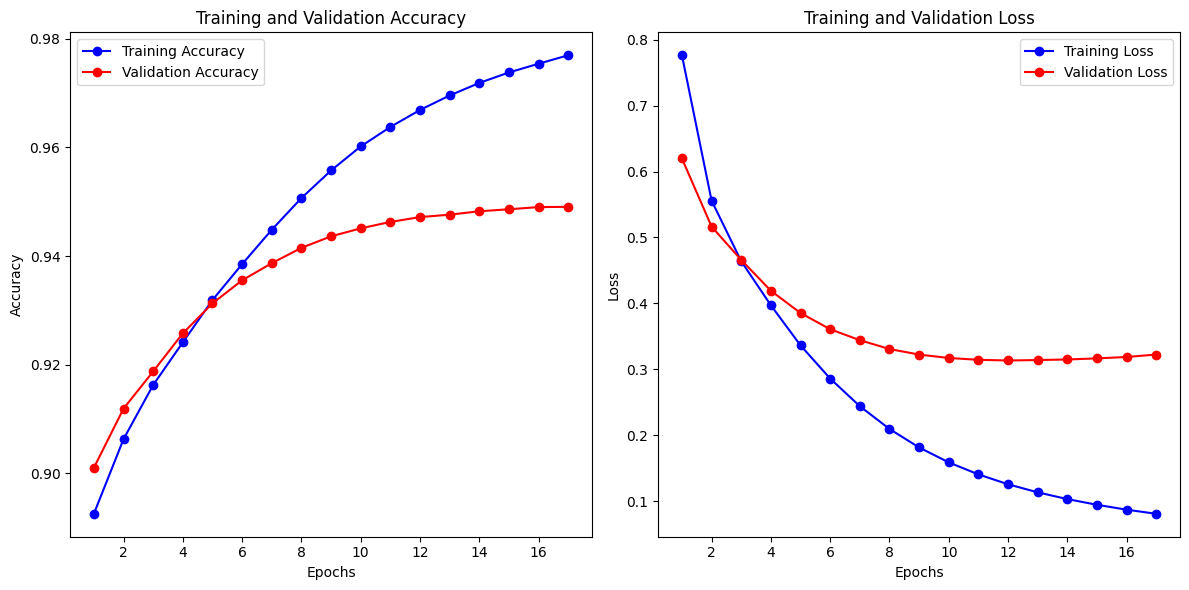

In [23]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Inference

In [12]:
model = load_model("models/english_to_french_translation.h5")

In [13]:
def translate_sentence(input_sentence, model, english_tokenizer, french_tokenizer, max_english_len, max_french_len):
    input_sequence = english_tokenizer.texts_to_sequences([input_sentence])
    input_padded = pad_sequences(input_sequence, maxlen=max_english_len, padding="post")

    target_sequence = np.array([[french_tokenizer.word_index["<start>"]]])
    translated_sentence = ""

    for _ in range(max_french_len):
        predictions = model.predict([input_padded, target_sequence], verbose=0)
        next_token_id = np.argmax(predictions[0, -1, :])

        next_word = french_tokenizer.index_word.get(next_token_id, "<unknown>")

        if next_word == "<end>":
            break

        translated_sentence += " " + next_word
        target_sequence = np.append(target_sequence, [[next_token_id]], axis=1)

    return translated_sentence.strip()

In [17]:
english_input = "Go ahead"
translated_output = translate_sentence(
    input_sentence=english_input,
    model=model,
    english_tokenizer=english_tokenizer,
    french_tokenizer=french_tokenizer,
    max_english_len=max_english_len,
    max_french_len=max_french_len
)

print("Translated Sentence:", translated_output)

Translated Sentence: vasy
